# Inspecting pulsar frequency data

We have produced some data using the methods in `scripts/generate_frequency_timeseries.py`

Lets load this data and make sure everything looks reasonable

First, load and plot the timeseries

In [7]:
import numpy as np 

data = np.load('../output_data/frequency_timeseries.npz')
data.files

['f_tim_file', 'f_par_file']

In [8]:
y = data['f_tim_file']

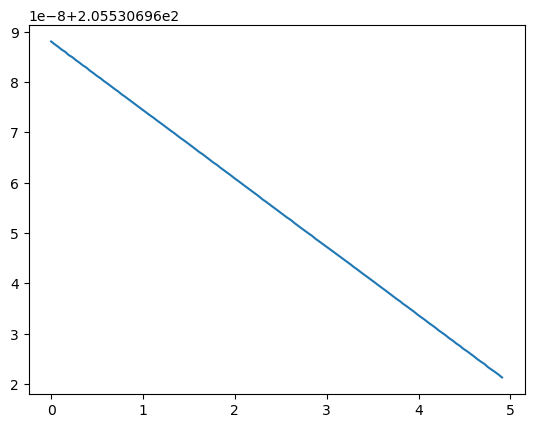

In [10]:
import matplotlib.pyplot as plt 

t = y[:,-1] / (365*24*3600)
f = y[:,0]
plt.plot(t,f)


Looks reasonable. 


Now lets look at the par file 

In [18]:
parameter_file = data['f_par_file']
f0 = parameter_file[0,:]
f1 = parameter_file[1,:]

In [19]:
print(f0)
print(f1)

[205.53069609 430.46105967 173.68794349 326.60055713  34.65740664
 182.11723205 287.45785417  90.01184199 190.26783467  60.77944703
 193.71568357 133.79314752 125.20024339 277.93770279  67.3765801
 316.12397941 216.3733342  218.81184052 123.11028528 188.23350935
 170.93737004 266.86916997 245.42611594 255.43611104 244.39137412
 186.49407848 339.31568215 200.6588023  130.78951216 641.92825115
 163.04791087 254.16034165 202.79389074 268.35922326  62.29588689
 290.25460377]
[-4.30603886e-16 -1.43396239e-14 -1.72840265e-15 -1.02284339e-15
 -5.66919939e-17 -4.93565492e-16 -6.43852823e-16 -3.97817055e-16
 -6.20038244e-16 -1.60086811e-16 -6.97595139e-16 -3.16621273e-16
 -3.80194788e-16 -7.34257113e-16 -7.08244036e-17 -2.81634305e-16
 -8.64635005e-16 -4.07884965e-16 -3.06205804e-16 -5.03072970e-16
 -7.03442656e-16  0.00000000e+00 -5.37149189e-16 -7.35231169e-16
 -5.28249712e-16 -6.15688471e-16 -1.61440986e-15 -3.93072964e-16
 -4.39673197e-16 -4.33164201e-14 -7.89809175e-16 -4.53505805e-16
 -8.

also looks reasonable...